# Imports

In [211]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Data Load

In [212]:
df_raw = pd.read_csv('../data/df_ready.csv')

In [213]:
df_raw.columns

Index(['Unnamed: 0', 'Date_imp', 'Date_imp_d', 'Cluster', 'Category_name',
       'name', 'price', 'disc_price', 'merchant', 'condition',
       'Disc_percentage', 'isSale', 'Imp_count', 'brand', 'p_description',
       'currency', 'dateAdded', 'dateSeen', 'dateUpdated', 'imageURLs',
       'manufacturer', 'shipping', 'sourceURLs', 'weight', 'Date_imp_d.1',
       'Day_n', 'month', 'month_n', 'day', 'Week_Number', 'Zscore_1',
       'price_std'],
      dtype='object')

In [214]:
df_raw = df_raw.drop(columns=['Unnamed: 0', 'Cluster',
        'condition','Disc_percentage', 'isSale', 'Imp_count', 'p_description',
       'currency', 'dateAdded', 'dateSeen', 'dateUpdated', 'imageURLs',
       'shipping', 'sourceURLs', 'weight', 'Date_imp_d.1',
       'Zscore_1','price_std'])

df_raw.columns = ['date_imp','date_imp_d', 'category_name', 'name', 'price', 'disc_price', 'merchant', 'brand', 'manufacturer','day_n', 'month', 'month_n', 'day', 'week_number']

# 1.0 Descrição dos Dados

In [215]:
df1 = df_raw.copy()

## 1.1 Dimensão dos Dados

In [216]:
df1.shape

(23151, 14)

## 1.2 Tipo dos Dados

In [217]:
df1.dtypes

date_imp          object
date_imp_d        object
category_name     object
name              object
price            float64
disc_price       float64
merchant          object
brand             object
manufacturer      object
day_n             object
month              int64
month_n           object
day                int64
week_number        int64
dtype: object

## 1.3 Check Na

In [218]:
df1.isna().sum()

date_imp             0
date_imp_d           0
category_name        0
name                 0
price                0
disc_price           0
merchant             0
brand                0
manufacturer     10639
day_n                0
month                0
month_n              0
day                  0
week_number          0
dtype: int64

## 1.4 Change Data Types

In [219]:
df1['date_imp_d'] = pd.to_datetime(df1['date_imp_d'])

## 1.5 Estatística Descritiva

In [220]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

In [221]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,1.0,10879.95,10878.95,513.037803,199.99,859.091448,4.595160,34.411146
1,disc_price,1.0,10879.95,10878.95,494.104295,199.00,808.571509,4.748349,39.612839
2,month,1.0,12.00,11.00,7.651030,8.00,2.592787,-0.099417,-0.628859
3,day,1.0,31.00,30.00,15.693879,16.00,9.681413,0.032258,-1.331838
4,week_number,1.0,51.00,50.00,31.342750,32.00,11.316253,-0.266980,-0.648027


# 2.0 Feature Engineering

In [222]:
df2 = df1.copy()

In [223]:
df_best = df2.loc[(df2['category_name'] == 'laptop, computer') & (df2['merchant'] == 'Bestbuy.com')]

In [224]:
df_agg = df_best.groupby(['name','week_number']).agg({'disc_price':'mean', 'date_imp': 'count'}).reset_index()

In [225]:
# orientando pelo preço
x_price = df_agg.pivot(index='week_number',columns='name',values='disc_price')

#orientando pela demanda
y_demand = df_agg.pivot(index='week_number',columns='name',values='date_imp')

# 3.0 Descrição dos Novos Dados

## 3.1 Dimensão dos Dados

In [226]:
x_price.shape

(26, 39)

In [227]:
y_demand.shape

(26, 39)

## 3.2 Tipo dos Dados

In [228]:
#x_price.dtypes
#y_demand.dtypes

## 3.3 Check Na

In [229]:
x_price.isna().sum()

name
12 MacBook (Mid 2017, Gold)                                                                                                                                                                            17
12 MacBook (Mid 2017, Silver)                                                                                                                                                                          18
12.3 32GB Multi-Touch 2-in-1 Chromebook Plus                                                                                                                                                           13
13.3 MacBook Air (Mid 2017, Silver)                                                                                                                                                                    21
15.4 MacBook Pro with Touch Bar (Late 2016, Silver)                                                                                                                                        

In [230]:
y_demand.isna().sum()

name
12 MacBook (Mid 2017, Gold)                                                                                                                                                                            17
12 MacBook (Mid 2017, Silver)                                                                                                                                                                          18
12.3 32GB Multi-Touch 2-in-1 Chromebook Plus                                                                                                                                                           13
13.3 MacBook Air (Mid 2017, Silver)                                                                                                                                                                    21
15.4 MacBook Pro with Touch Bar (Late 2016, Silver)                                                                                                                                        

## 3.4 Replace Na

In [231]:
median_price = np.round(x_price.median(),2)
x_price.fillna(median_price, inplace=True)

In [232]:
y_demand.fillna(0, inplace=True)

## 3.5 Estatística Descritiva

In [233]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( x_price.apply( np.mean ) ).T
ct2 = pd.DataFrame( x_price.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( x_price.apply( np.std ) ).T 
d2 = pd.DataFrame( x_price.apply( min ) ).T 
d3 = pd.DataFrame( x_price.apply( max ) ).T 
d4 = pd.DataFrame( x_price.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( x_price.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( x_price.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,"12 MacBook (Mid 2017, Gold)",1454.990,1599.99,145.000,1547.124615,1551.99,25.648346,-2.457686,8.310054
1,"12 MacBook (Mid 2017, Silver)",1234.990,1299.99,65.000,1295.990000,1299.99,14.317821,-3.735032,13.784949
2,12.3 32GB Multi-Touch 2-in-1 Chromebook Plus,372.995,449.00,76.005,413.189808,415.50,15.423120,-1.054924,2.830858
3,"13.3 MacBook Air (Mid 2017, Silver)",911.990,969.99,58.000,949.297692,949.99,8.393080,-2.975611,16.702015
4,"15.4 MacBook Pro with Touch Bar (Late 2016, Si...",2327.990,2799.99,472.000,2607.393846,2618.99,112.833610,-1.131897,2.049122
5,"15.4 MacBook Pro with Touch Bar (Late 2016, Sp...",2023.990,2599.99,576.000,2346.913077,2353.99,122.523757,-0.274833,1.347179
6,ASUS VivoBook Max X541SA 15.6Inch Laptop Intel...,237.490,313.49,76.000,299.720769,304.99,16.347918,-2.916993,8.218479
7,Acer - 2-in-1 15.6 Refurbished Touch-Screen La...,764.990,899.99,135.000,834.028462,829.99,27.804926,0.937281,2.943939
8,Acer 15.6 Chromebook CB5-571-C4G4,199.990,249.00,49.010,242.479231,249.00,14.017001,-2.306458,4.514429
9,Alienware - R3 17.3 Laptop - Intel Core i7 - 1...,1599.990,1899.99,300.000,1879.643846,1899.99,71.165540,-3.486137,11.301211


In [234]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( y_demand.apply( np.mean ) ).T
ct2 = pd.DataFrame( y_demand.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( y_demand.apply( np.std ) ).T 
d2 = pd.DataFrame( y_demand.apply( min ) ).T 
d3 = pd.DataFrame( y_demand.apply( max ) ).T 
d4 = pd.DataFrame( y_demand.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( y_demand.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( y_demand.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,"12 MacBook (Mid 2017, Gold)",0.0,8.0,8.0,0.961538,0.0,1.764626,2.738840,9.024976
1,"12 MacBook (Mid 2017, Silver)",0.0,2.0,2.0,0.384615,0.0,0.624926,1.474017,1.189701
2,12.3 32GB Multi-Touch 2-in-1 Chromebook Plus,0.0,4.0,4.0,1.038462,0.5,1.125945,0.606680,-0.428079
3,"13.3 MacBook Air (Mid 2017, Silver)",0.0,2.0,2.0,0.384615,0.0,0.788227,1.658711,0.807453
4,"15.4 MacBook Pro with Touch Bar (Late 2016, Si...",0.0,6.0,6.0,1.153846,0.0,1.609881,1.437577,1.673167
5,"15.4 MacBook Pro with Touch Bar (Late 2016, Sp...",0.0,12.0,12.0,3.230769,1.0,3.885948,0.951022,-0.225438
6,ASUS VivoBook Max X541SA 15.6Inch Laptop Intel...,0.0,2.0,2.0,0.538462,0.0,0.887120,1.105353,-0.849951
7,Acer - 2-in-1 15.6 Refurbished Touch-Screen La...,0.0,2.0,2.0,0.384615,0.0,0.624926,1.474017,1.189701
8,Acer 15.6 Chromebook CB5-571-C4G4,0.0,4.0,4.0,0.769231,1.0,0.932643,1.711207,4.066693
9,Alienware - R3 17.3 Laptop - Intel Core i7 - 1...,0.0,2.0,2.0,0.615385,1.0,0.624926,0.534925,-0.518213


# 4.0 EDA

<AxesSubplot:xlabel='name', ylabel='demand'>

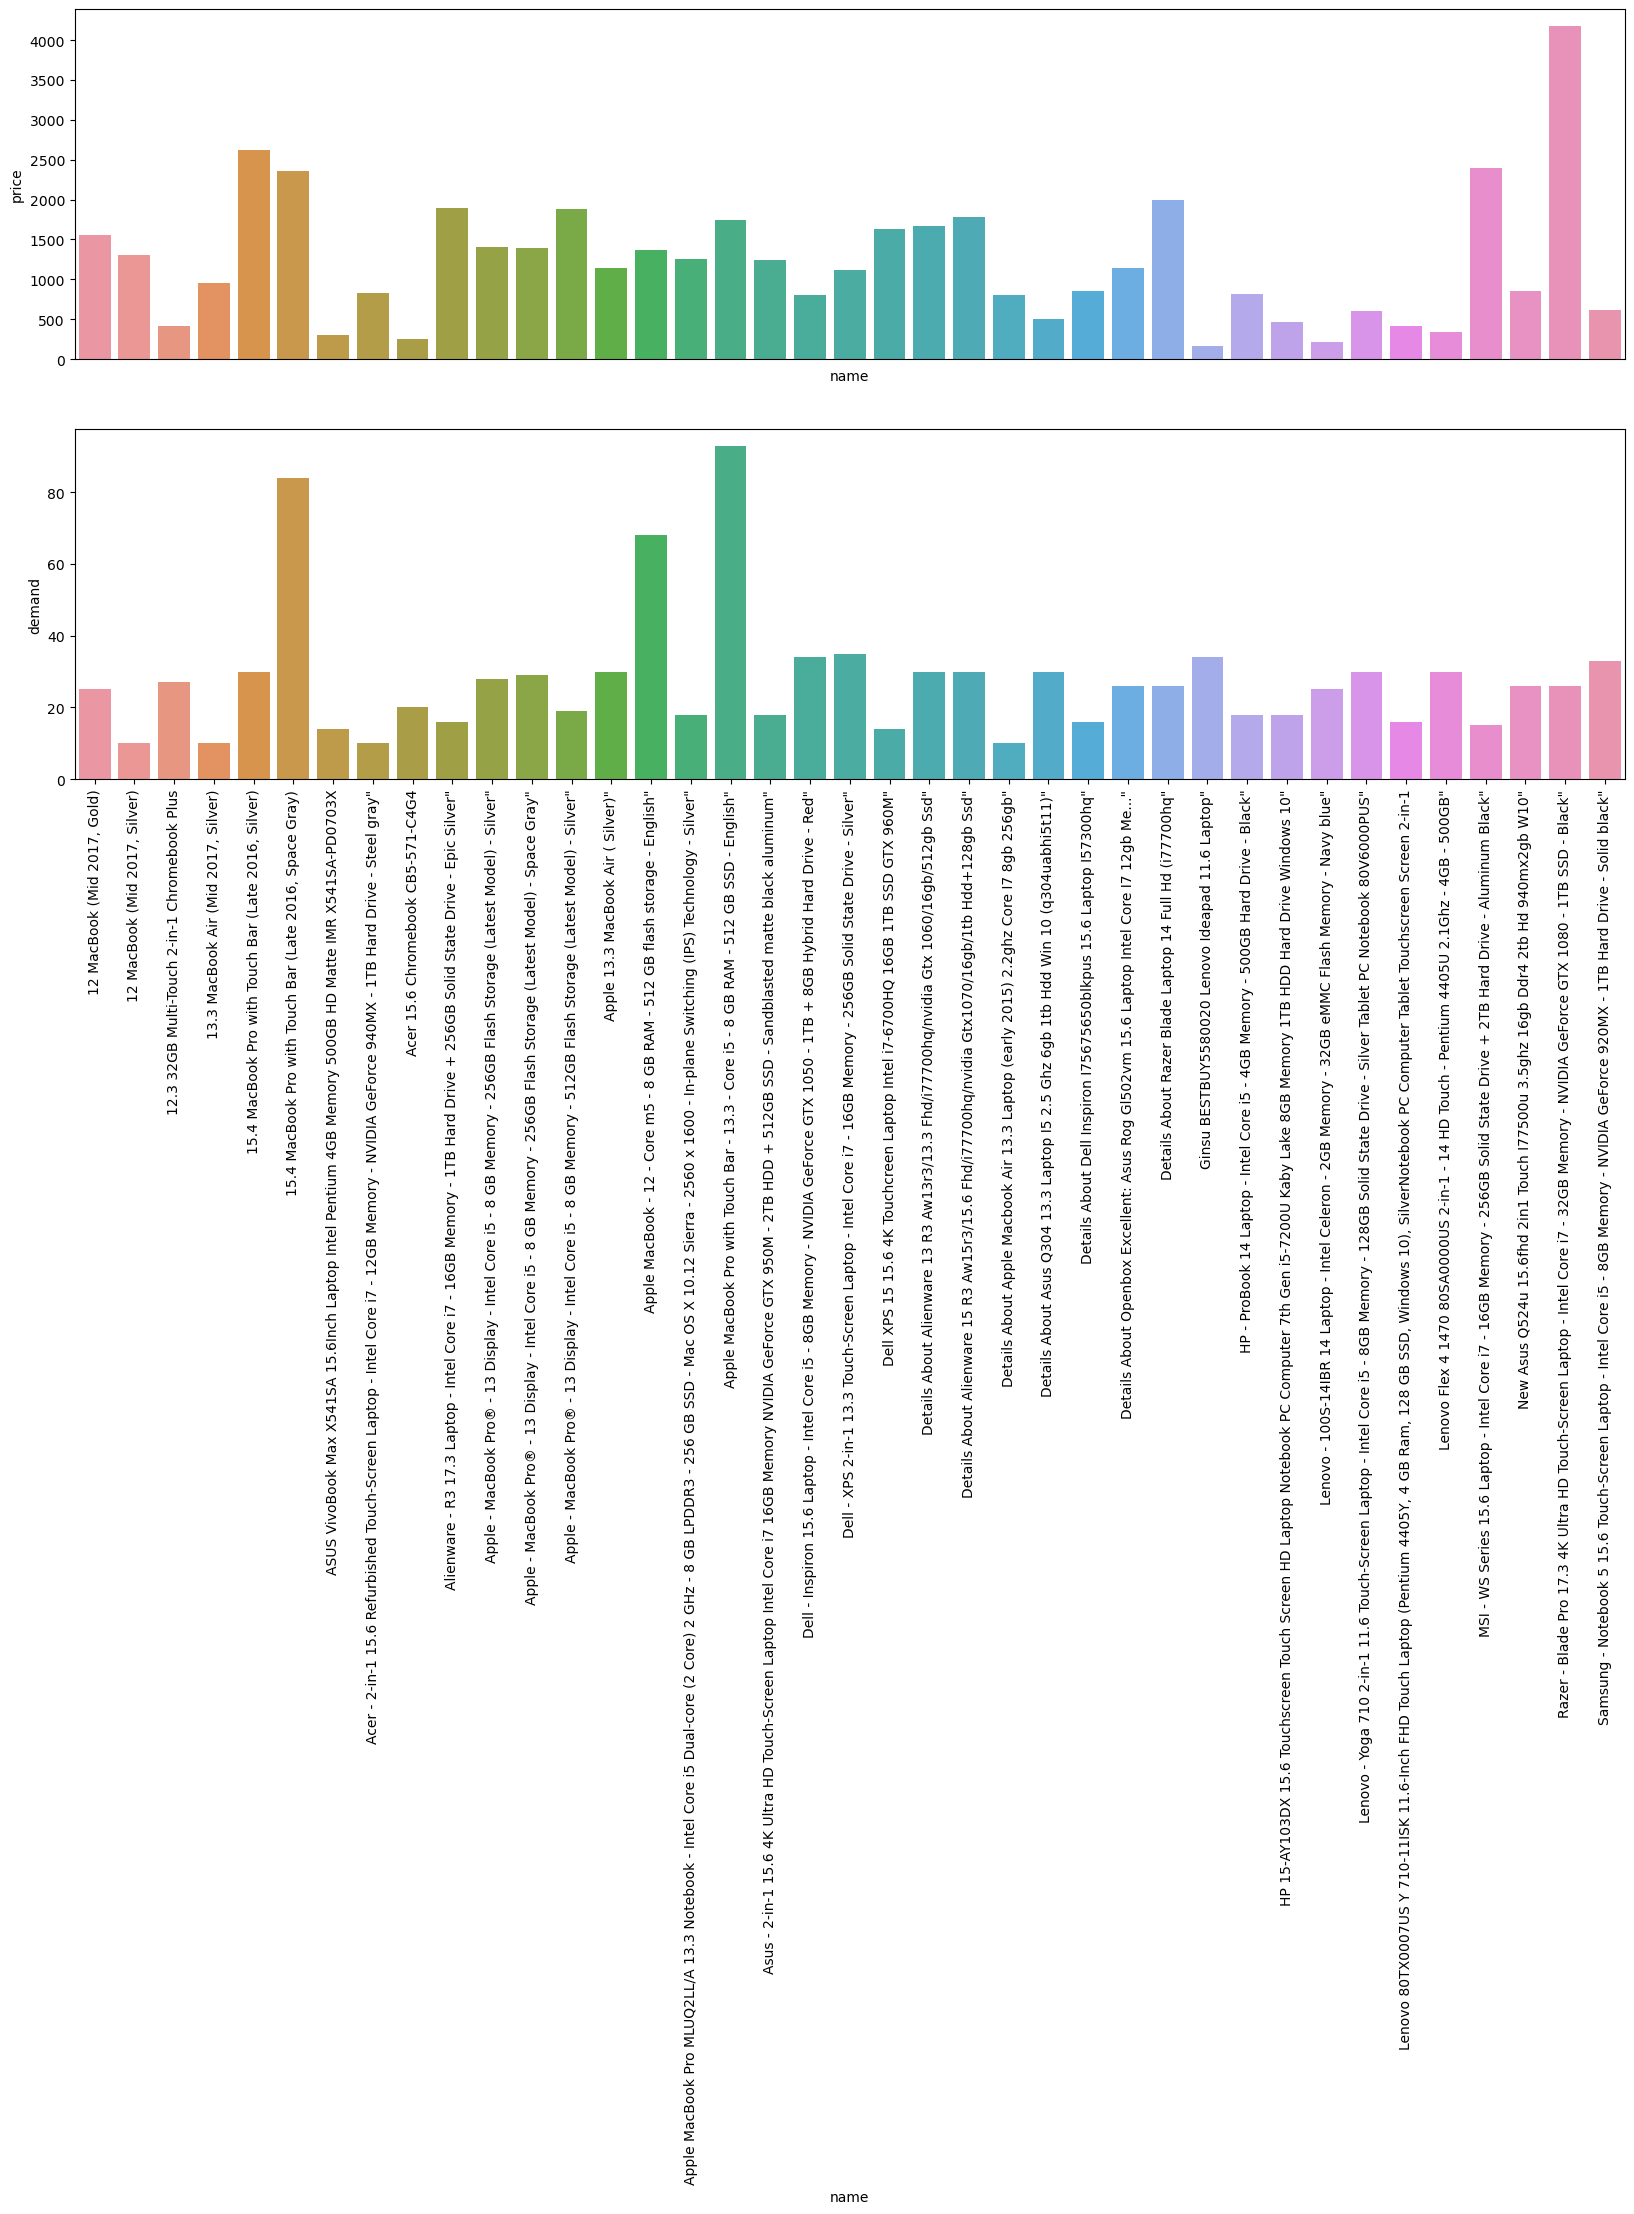

In [235]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
aux = pd.DataFrame(x_price.apply(lambda x: x.median())).reset_index()
aux.columns = ['name','price']
sns.barplot(x='name', y='price',data=aux)
plt.xticks([])

plt.subplot(2,1,2)
aux2 = pd.DataFrame(y_demand.apply(lambda x: x.sum())).reset_index()
aux2.columns = ['name','demand']
plt.xticks(rotation=90)
sns.barplot(x='name', y='demand',data=aux2)

In [236]:
# plt.figure(figsize=(20,60))
# for k in range(1,len(x_price.reset_index().columns),1):
#     plt.subplot(20,2,k)
#     sns.barplot(data= x_price, x=x_price.reset_index()['week_number'], y=x_price[x_price.columns[k]])
#     plt.title(a[k-1])
#     plt.ylabel('')
#     plt.tight_layout()

    

# 5.0 Machine Learning

## 5.1 Exemplo para apenas um produto

In [237]:
import statsmodels.api as sm
x_price1 = x_price['12 MacBook (Mid 2017, Gold)']
y_demand1 = y_demand['12 MacBook (Mid 2017, Gold)']


X = sm.add_constant(x_price1)
model = sm.OLS(y_demand1, X)
results = model.fit()


results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     12 MacBook (Mid 2017, Gold)   R-squared:                       0.081
Model:                                     OLS   Adj. R-squared:                  0.042
Method:                          Least Squares   F-statistic:                     2.108
Date:                         Sun, 25 Jun 2023   Prob (F-statistic):              0.159
Time:                                 19:55:00   Log-Likelihood:                -50.564
No. Observations:                           26   AIC:                             105.1
Df Residuals:                               24   BIC:                             107.6
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          31.2066     20.835      1.498      0.147     -11.795      74.208
12 MacBook (Mid 2017, Gold)    -0.0195      0.013     -1.452      0.159      -0.047       0.008
==============================================================================
Omnibus:                       39.538   Durbin-Watson:                   1.513
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.539
Skew:                           2.893   Prob(JB):                     7.43e-29
Kurtosis:                      12.279   Cond. No.                     9.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 6.2 ML to All Products

In [238]:
#x_price.reset_index(drop=True)['12 MacBook (Mid 2017, Gold)'][0]
x_price.reset_index(drop=True)['12 MacBook (Mid 2017, Silver)'][0]

1299.99

In [239]:
#y_demand
y_demand.reset_index(drop=True)['12 MacBook (Mid 2017, Silver)'][0]

0.0

In [240]:
results_values_laptop = {
    "name": [],
    "price_elastity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "slope": [],
    "rsquared": [],
    "p_value": []

}

df = pd.DataFrame()
for column in x_price.columns:
    #print(column)
    list_price = []
    list_demand = []
    column_points = []
    for i in range(len(x_price[column])):
        column_points.append({'x_price': x_price.reset_index(drop=True)[column][i],
                            'y_demand': y_demand.reset_index(drop=True)[column][i]})
        
        list_price.append(column_points[i]['x_price'])
        list_demand.append(column_points[i]['y_demand'])


    X = sm.add_constant(list_price)
    model = sm.OLS(list_demand, X)
    results = model.fit()

    if results.f_pvalue < 0.05:
        rsquared = results.rsquared
        pvalue = results.f_pvalue
        intercept, slope = results.params
        
        mean_price = np.round(np.mean(list_price),2)
        mean_quantity = np.round(np.mean(list_demand),2)


        price_elastity = slope*(mean_price/mean_quantity)

        results_values_laptop['name'].append(column)
        results_values_laptop['price_elastity'].append(price_elastity)
        results_values_laptop['rsquared'].append(rsquared)
        results_values_laptop['p_value'].append(pvalue)
        results_values_laptop['intercept'].append(intercept)
        results_values_laptop['slope'].append(slope)
        results_values_laptop['price_mean'].append(mean_price)
        results_values_laptop['quantity_mean'].append(mean_quantity)
df_elastity = pd.DataFrame(results_values_laptop)

In [241]:
# list_price = []
# list_demand = []
# for i in range(len(column_points)):
#     list_price.append(column_points[i]['x_price'])
#     list_demand.append(column_points[i]['y_demand'])
# mean_price = np.mean(list_price)
# mean_quantity = np.mean(list_demand)




In [242]:
df_elastity

,name,price_elastity,price_mean,quantity_mean,intercept,slope,rsquared,p_value
0,"12 MacBook (Mid 2017, Silver)",-65.906473,1295.99,0.38,25.429075,-0.019325,0.196027,0.023508
1,ASUS VivoBook Max X541SA 15.6Inch Laptop Intel...,-15.993905,299.72,0.54,9.175192,-0.028816,0.281984,0.005251
2,Acer 15.6 Chromebook CB5-571-C4G4,-8.424147,242.48,0.77,7.255804,-0.026751,0.161645,0.041743
3,Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - In...,-6.038766,1224.22,0.69,4.859060,-0.003404,0.236464,0.011774
4,Dell - Inspiron 15.6 Laptop - Intel Core i5 - ...,-23.162684,790.76,1.31,31.650779,-0.038372,0.327839,0.002237
5,Details About Apple Macbook Air 13.3 Laptop (e...,-68.993714,795.51,0.38,26.602201,-0.032957,0.510312,0.000041
6,Lenovo - 100S-14IBR 14 Laptop - Intel Celeron ...,-6.059004,209.66,0.96,6.778268,-0.027743,0.277667,0.005677
